### Imports and Helper Functions

In [1]:
import sys
import numpy as np
import functools
from difflib import SequenceMatcher
import nltk
#nltk.download('averaged_perceptron_tagger')

import os
import dtale
import dtale.app as dtale_app
dtale_app.JUPYTER_SERVER_PROXY = True
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.5f' % x)
import canalyst_candas.candas as cd
import canalyst_candas.candas_datareader as cdr
from canalyst_candas.configuration.config import Config
config_info = {
  "canalyst_api_key": "",
  "s3_access_key_id": "",
  "s3_secret_key": "",
  "fred_key": "",
  "default_dir": "",
  "mds_host": "",
  "wp_host": ""
}
config = Config(config=config_info)
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)

#helper functions which will move into the base candas library next release
def remove(target, strings):    
    ans = nltk.pos_tag([target])
    val = ans[0][1]
    if(val == 'NN' or val == 'NNS' or val == 'NNPS' or val == 'NNP'):    
        for s in strings:
            if target==s:
                target=""
    else:
        target =""
    return target

def score_lists(list1,list2,ignore_list):
    list1 = [s.replace(",", "") for s in list1]
    list2 = [s.replace(",", "") for s in list2]
    
    score=0
    x = len(list2)
    num_matches = 0
    for ii,s in enumerate(list1):
        
        if s in ignore_list:
            continue
            
        if s in list2:
            ans = nltk.pos_tag([s])
            val = ans[0][1]
            if(val == 'NN' or val == 'NNS' or val == 'NNPS' or val == 'NNP'):        
                num_matches += 1
                i = list2.index(s)+1
                z = list1.index(s)+1
                x = z/i/(ii+1)
                score=score+x
    if num_matches:
        score = score * num_matches/len(list2)
    return score

def kpi_match(df,time_series_description,unit_type,n_return):
    ignore_list = ["","significant","growth","effective","other","items","one-time","net","income","y/y","change","consensus","share","price","estimated","dividend","buybacks","adjustments","tax","issuance",'%', ',', 'mm', ' ','-','&','and','#',' of','bn']
    
    split_description = list(set(time_series_description.lower().split(" ")))
    list_out = []
    list_out.append(["time_series_description","time_series_name","word_score","diff_score"])
    
    for i,row in df.iterrows():
        row_description = str(row['time_series_description'])
        row_name = str(row['time_series_name'])
        row_unit_type = str(row['unit_type'])
        split_row = list(set(row_description.lower().split(" ")))
        
        if unit_type != "" and row_unit_type != unit_type:
            continue
        word_score = score_lists(split_description,split_row,ignore_list)
        diff_score = SequenceMatcher(None,time_series_description,row_description).ratio()
        if word_score > 0:
            list_out.append([row_description,row_name,word_score,diff_score])
        
    df = pd.DataFrame(list_out)
    df.columns = df.iloc[0] 
    df = df[1:]
    df['diff_rank'] = df['diff_score'].rank(pct=True)
    df['word_score_rank'] = df['word_score'].rank(pct=True)
    df['rank'] = df['word_score_rank']+df['diff_rank']
    df['rank'] = df['rank'].rank(pct=True)
    df = df.sort_values(['rank'],ascending=False).head(n_return)
    return df
    


A configuration file has been created for you in 
/home/canalyst-candas/canalyst/keys.json. For Excel file downloads and scenario 
mapping, you'll need to add an API key to the 'canalyst_api_key' 
value. Visit https://app.canalyst.com/settings/api-tokens to create 
and retrieve your API key. You will also need to retrieve your 
S3 Access ID and Secret Key and fill in 'canalyst_s3_id' and 
'canalyst_s3_key' with those values, respectively. If using a 
Jupyter Notebook, stop and restart the notebook for the changes to 
take effect. If using a Python/iPython session, quit the current 
session and start a new one.


## Drive a Target company with JPM 4q results
### First, instantiate a target company ModelSet

In [2]:
ticker = "AXP US"
yahoo_ticker = "AXP" #need this for prices
index_ticker = "^GSPC" #this is our benchmark index (^GSPC for S&P 500, EFA for msci eafa etc)
alpha_days = "alpha_1_day" #or alpha_5_day or alpha_10_day
regression_window = 12
target_model_set = cd.ModelSet(ticker_list=[ticker], config=config) 

### Use Candas ModelMap() to view the Revenue Build for the target
#### Lower left of the model, red triangle, shows WorldWide Network Volume 

In [3]:
#model_set = cd.ModelSet(ticker_list=[ticker], config=config) #create a modelset of our ticker
time_series_name="MO_RIS_REV"
model_map = target_model_set.create_model_map(ticker=ticker,
                            time_series_name=time_series_name,
                            tree = True,
                            notebook = True,
                            col_for_labels = "time_series_description") 
model_map.show()

https://mds.canalyst.com/api/equity-model-series/FYXPQQ0114/equity-models/Q3-2021.21/time-series/MO_RIS_REV/forecast-data-points/Q4-2021/drivers/?format=dot


### Next, instantiate the JPM ModelSet
#### Use the MRQ function to check that it is updated for Q4 2021

In [4]:
ticker = "JPM US"
jpm_model_set = cd.ModelSet(ticker_list=[ticker], config=config) 
jpm_model_set.models[ticker].mrq()

,period_name,period_end_date
0,Q4-2021,2021-12-31


### Create searchable KPI sets for each company

In [5]:
df_jpm_kpi = jpm_model_set.model_frame(mrq=True)[['time_series_name','time_series_description','unit_type']]
df_target_kpi = target_model_set.model_frame(mrq=True)[['time_series_name','time_series_description','unit_type']]

### Use the kpi_match() function to find "Volume" in the target company KPI list
#### We find "WorldWide Network Volume Growth %" as the top match

In [6]:
kpi_match(df_target_kpi,"volume","",10)

,time_series_description,time_series_name,word_score,diff_score,diff_rank,word_score_rank,rank
1,"Worldwide Network volume Growth, %",MO_GA_TPV,0.06667,0.30000,1.00000,1.00000,1.00000
2,"Worldwide Card Member Receivables - GCP Net loss ratio as a % of charge volume, %",z_FYXPQQ0114_MO_OS_WorldwideCardMemberReceivablesGCP90dayspastbillingasaoftotal,0.00741,0.13793,0.50000,0.50000,0.50000


### Now we create a regression dataframe
#### Use the Credit Card Sales Volume numbers from JPM (converted to annual) 
#### And the WorldWide Network volume Growth time series we found above.

In [7]:
df_jpm_ts = jpm_model_set.model_frame(
                      period_duration_type='fiscal_quarter',
                      is_historical=True,
                      time_series_name='z_3FRM7X0148_MO_OS_Creditcardsalesvolume')[['ticker','time_series_name','period_end_date','value']].head(-1)
df_jpm_ts['value']=df_jpm_ts['value'].pct_change(4)*100

In [8]:
#z_2CRCA60110_MO_OS_usconsumercreditpaymentsvolume
#z_2CRCA60110_MO_OS_YYChangeinVisaprocessedtransactionspercard
df_target_ts = target_model_set.model_frame(
                      period_duration_type='fiscal_quarter',
                      is_historical=True,
                      time_series_name='MO_GA_TPV')[['ticker','time_series_name','period_end_date','value']]

In [9]:
df = pd.merge(df_jpm_ts,df_target_ts,how='inner',left_on='period_end_date',right_on='period_end_date')[['period_end_date','value_x','value_y']].dropna()#.tail(8)
df.tail(8)

,period_end_date,value_x,value_y
23,2019-12-31,10.19968,5.24272
24,2020-03-31,3.82609,-5.54616
25,2020-06-30,-22.85714,-34.19955
26,2020-09-30,-8.00620,-19.30565
27,2020-12-31,-3.52595,-14.66790
28,2021-03-31,2.56840,-3.58038
29,2021-06-30,50.63973,54.11994
30,2021-09-30,30.26390,32.97145


### Now we can run a regression against our two time series

In [10]:
import statsmodels.formula.api as smf
mod = smf.ols(formula='value_x ~ value_y', data=df)
res = mod.fit()
res.summary().tables[0]

Dep. Variable:,value_x,R-squared:,0.914
Model:,OLS,Adj. R-squared:,0.911
Method:,Least Squares,F-statistic:,267.0
Date:,"Mon, 17 Jan 2022",Prob (F-statistic):,7.48e-15
Time:,13:49:10,Log-Likelihood:,-72.235
No. Observations:,27,AIC:,148.5
Df Residuals:,25,BIC:,151.1
Df Model:,1,,
Covariance Type:,nonrobust,,


### The plotted fit looks pretty good, R-squared is .91

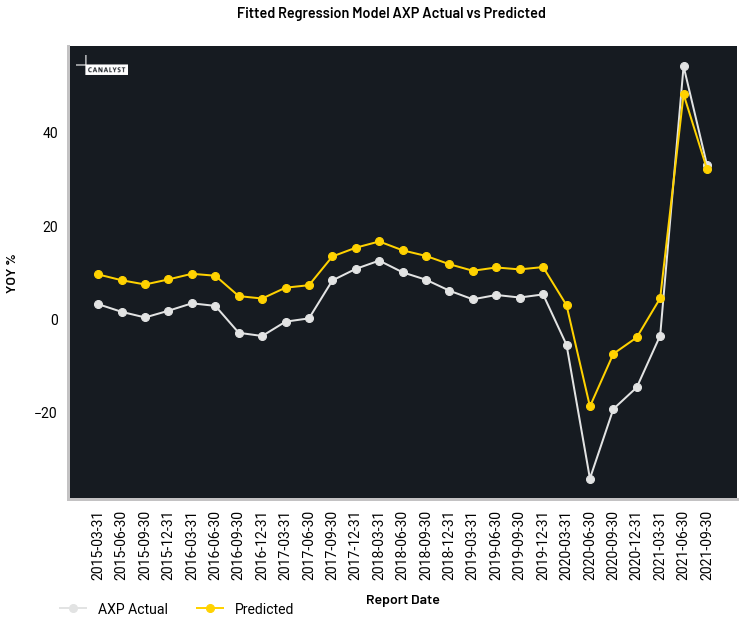

In [11]:
%matplotlib inline
df['predictions']=res.predict()
p = cd.Chart(df['period_end_date'],df[["value_y", "predictions"]],["AXP Actual", "Predicted"], [["Report Date", "YOY %"]], title="Fitted Regression Model AXP Actual vs Predicted")
p.show()


### Now let's get the Q4 JPM number we'll use for predicting Q4 of the target

In [12]:
jpm_pred = jpm_model_set.model_frame(
                      period_duration_type='fiscal_quarter',
                      is_historical=True,
                      time_series_name='z_3FRM7X0148_MO_OS_Creditcardsalesvolume')[['ticker','time_series_name','period_end_date','value']]
jpm_pred['value'] = jpm_pred['value'].pct_change(4)*100
jpm_pred.tail(1)

,ticker,time_series_name,period_end_date,value
32999,JPM US,z_3FRM7X0148_MO_OS_Creditcardsalesvolume,2021-12-31,28.98477


### And we can use our regression formula to forecast the target Q4 volume number

In [13]:
intercept = res.params[0]
beta = res.params[1]
new_jpm_value = 29
y = beta*new_jpm_value + intercept
print(y)

29.09129265591725


### We see the target Q4 2021 value of 18 in our model

In [14]:
target_model_set.model_frame(
                      period_duration_type='fiscal_quarter',
                      time_series_name='MO_GA_TPV')[['ticker','time_series_name','period_end_date','value']].tail(8)

,ticker,time_series_name,period_end_date,value
1051,AXP US,MO_GA_TPV,2021-03-31,-3.58038
1061,AXP US,MO_GA_TPV,2021-06-30,54.11994
1071,AXP US,MO_GA_TPV,2021-09-30,32.97145
1081,AXP US,MO_GA_TPV,2021-12-31,18.00000
1052,AXP US,MO_GA_TPV,2022-03-31,20.00000
1062,AXP US,MO_GA_TPV,2022-06-30,7.00000
1072,AXP US,MO_GA_TPV,2022-09-30,7.00000
1082,AXP US,MO_GA_TPV,2022-12-31,7.00000


### We are going to set that value to our forecasted number of 29

In [15]:
df_params = target_model_set.forecast_frame("MO_GA_TPV",
                             n_periods=-1,
                             function_name='value',
                             function_value=29)

# How much does revenue move?
return_series = "MO_RIS_REV"

dicts_output=target_model_set.fit(df_params,return_series)

AXP US scenario_id_url: https://mds.canalyst.com/api/equity-model-series/FYXPQQ0114/equity-models/Q3-2021.21/scenarios/8pECuguVWi682uzB-UKuog/


### This creates a 6% bump in revenues versus the Canalyst model

In [16]:
dicts_output['AXP US'].head(1)

,ticker,period_name,time_series_name,time_series_description,default,scenario,diff
0,AXP US,Q4-2021,MO_RIS_REV,Net Revenue,10843524586.67124,11514668604.1712,1.06189


### Which takes us to 11.5bn revenues vs the street of 11.47

In [17]:
cdr.get_revenue_estimates(yahoo_ticker)

,Revenue Estimate,Current Qtr. (Dec 2021),Next Qtr. (Mar 2022),Current Year (2021),Next Year (2022)
0,No. of Analysts,21,12,25,25
1,Avg. Estimate,11.47B,10.95B,41.75B,47.7B
2,Low Estimate,10.96B,10.2B,41.19B,45.21B
3,High Estimate,11.86B,11.41B,42.27B,49.77B
4,Year Ago Sales,9.35B,9.17B,36.09B,41.75B
5,Sales Growth (year/est),22.60%,19.40%,15.70%,14.20%


### We see here, the target usually beats EPS, and usually doesn't move much in subsequent trading

In [18]:
df = cdr.get_earnings_and_prices(yahoo_ticker,index_ticker = index_ticker) 
df.describe().reset_index() #row 2 is the mean of the full series of data

,index,epsestimate,epsactual,epssurprisepct,alpha_1_day,alpha_5_day,alpha_10_day,beta_252,plus_1_return,plus_5_return,plus_10_return,mktclose_plus_1_return,mktclose_plus_5_return,mktclose_plus_10_return
0,count,52.00000,52.00000,52.00000,48.00000,48.00000,48.00000,48.00000,52.00000,52.00000,52.00000,52.00000,52.00000,52.00000
1,mean,1.22154,1.30500,14.75442,-0.00556,-0.00294,-0.00250,1.18363,0.00027,0.00206,0.01247,0.00124,0.00043,0.00700
2,std,0.49912,0.59026,57.55508,0.03682,0.04422,0.04661,0.27785,0.04902,0.05900,0.06672,0.00946,0.01882,0.02680
3,min,-0.11000,0.09000,-71.25000,-0.13683,-0.16598,-0.15126,0.70094,-0.12101,-0.15581,-0.13186,-0.02568,-0.05639,-0.06662
4,25%,0.97750,1.00000,0.70250,-0.02226,-0.02301,-0.03315,1.05564,-0.02594,-0.03171,-0.03249,-0.00368,-0.00787,-0.00739
5,50%,1.29000,1.25000,2.73000,-0.00765,-0.00889,-0.00682,1.11523,-0.00742,0.00091,-0.00083,0.00208,0.00299,0.00917
6,75%,1.49500,1.62000,8.06000,0.01244,0.02147,0.03303,1.32205,0.01555,0.03290,0.05230,0.00678,0.01359,0.02344
7,max,2.04000,2.80000,354.39000,0.09137,0.09240,0.08563,2.24238,0.20649,0.20267,0.23844,0.02028,0.03537,0.06511


### The target company does not guide on revenues, nor do we have 2021 guidance

In [19]:
target_model_set.models["AXP US"].guidance()

,Unnamed: 0,Type,Item,Item Name,Fiscal Period,Low,High,Mid,Type.1,Output,Absolute,Relative,Date,Link
1,5,Historical,Earnings Per Share - WAB,MO_RIS_EPS_WAB,FY2020,8.85000,9.25000,9.05000,Actual,3.77143,-5.27857,-0.58327,2020-01-24 00:00:00,Press Release
3,7,Historical,Earnings Per Share - WAB,MO_RIS_EPS_WAB,FY2019,7.64000,8.14000,7.89000,Actual,8.00845,0.11845,0.01501,2019-10-18 00:00:00,Press Release
4,8,Historical,Adjusted Earnings Per Share - WAD,MO_RIS_EPS_WAD_Adj,FY2019,7.85000,8.35000,8.10000,Actual,8.20245,0.10245,0.01265,2019-10-18 00:00:00,Press Release
6,10,Historical,Earnings Per Share - WAB,MO_RIS_EPS_WAB,FY2019,7.64000,8.14000,7.89000,Actual,8.00845,0.11845,0.01501,2019-07-19 00:00:00,Press Release
7,11,Historical,Adjusted Earnings Per Share - WAD,MO_RIS_EPS_WAD_Adj,FY2019,7.85000,8.35000,8.10000,Actual,8.20245,0.10245,0.01265,2019-07-19 00:00:00,Press Release
9,13,Historical,Earnings Per Share - WAB,MO_RIS_EPS_WAB,FY2019,7.64000,8.14000,7.89000,Actual,8.00845,0.11845,0.01501,2019-04-18 00:00:00,Press Release
10,14,Historical,Adjusted Earnings Per Share - WAD,MO_RIS_EPS_WAD_Adj,FY2019,7.85000,8.35000,8.10000,Actual,8.20245,0.10245,0.01265,2019-04-18 00:00:00,Press Release
12,16,Historical,Earnings Per Share - WAB,MO_RIS_EPS_WAB,FY2018,6.90000,7.30000,7.10000,Actual,7.92874,0.82874,0.11672,2018-07-18 00:00:00,Press Release
14,18,Historical,Earnings Per Share - WAB,MO_RIS_EPS_WAB,FY2018,6.90000,7.30000,7.10000,Actual,7.92874,0.82874,0.11672,2018-04-18 00:00:00,Press Release


### Conclusion: 
#### <li> JPM results caused us to revise our AXP revenue estimates upwards by 6%
#### <li> We are now slightly ahead of the Street
#### <li> However, AXP tends to beat earnings but AXP stock does not show subsequent alpha, on average over 52 observations
#### <li> It is likely therefore that buyside estimates tend to sit higher than Street estimates for this company

In [20]:
ticker="AXP US"
df_data = target_model_set.pe_dataset(ticker,yahoo_ticker,index_ticker)
categories = list(target_model_set.model_frame(ticker=ticker,
                      period_duration_type = "fiscal_quarter", 
                      mrq=True)['category'].unique())

like_list = ['Stats','Analysis','Metrics','Segmented Results']
category_filter = []
for category in categories:
    for like in like_list:
        if like in category:
            category_filter.append(category)
            
category_filter = list(set(category_filter))
%matplotlib inline
df_kpi = cdr.regress_dataframe_time_series_groups(df_data = df_data,
                                         y_name=alpha_days,
                                         return_grouped=True,
                                         category = category_filter,
                                         n_periods=regression_window)
df_kpi = df_kpi[['ticker','time_series_description','time_series_name','category','rsquared']].head(10).sort_values('rsquared',ascending = True)
#df_kpi.plot(x='time_series_description',y='rsquared',kind='barh',title=ticker+" Key Drivers Price Sensitivity")

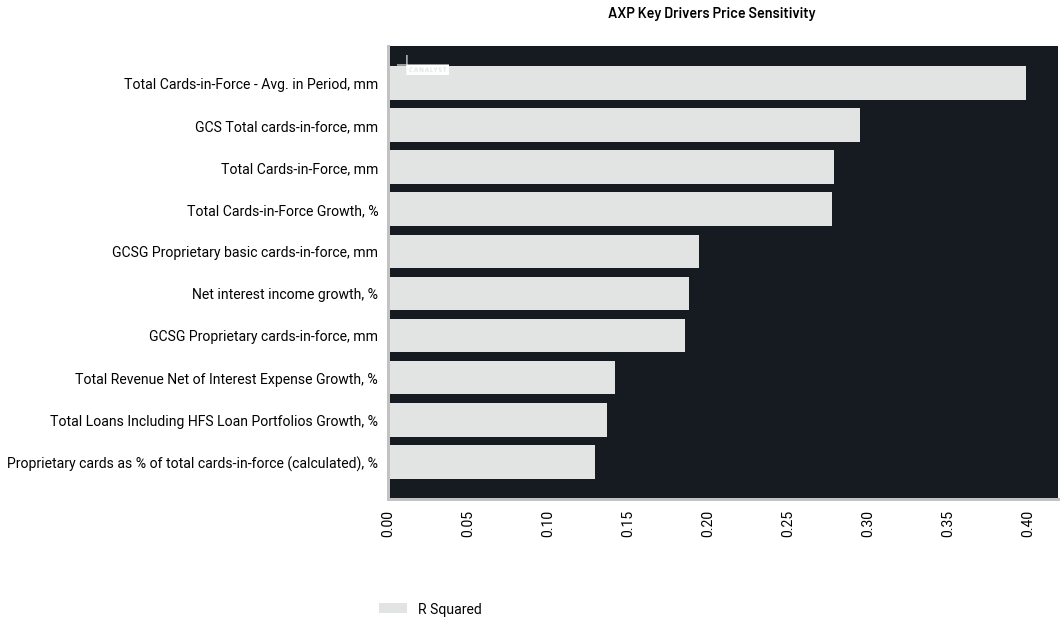

In [21]:
#df_kpi.plot(x='time_series_description',y='rsquared',kind='barh',title=ticker+" Key Drivers Price Sensitivity")
p = cd.Chart(df_kpi['time_series_description'],df_kpi[["rsquared"]],["R Squared"], [["", ""]], title="AXP Key Drivers Price Sensitivity",plot_styles=["barh"])
p.show()
